In [1]:
# Another quick start example on how one might write a metric for a transient population

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import rubin_sim.maf as maf
import healpy as hp
from rubin_sim.data import get_baseline

In [3]:
# Need a database to work on. You can grab this one from: 
# http://astro-lsst-01.astro.washington.edu:8080/fbs_db/fbs_2.99/draft/draft_connected_v2.99_10yrs.db

# all the columns in the database documented at: https://rubin-sim.lsst.io/rs_scheduler/output_schema.html

# or just use the baseline that comes with rubin_sim
filename = get_baseline()
run_name = filename.replace('.db', '')


In [4]:
# very simple. Probably want to actually compute things per filter
# Can also add more/different parameters for the shape of the light curve
def simple_light_curve(nights, peak_times, amplitude, duration, mag=22):
    result = nights*0 + mag
    boosted_indx = np.where((nights >= peak_times) & (nights <= (peak_times + duration)))[0]
    result[boosted_indx] -= amplitude  # negative since magnitudes are backwards
    
    return result

In [5]:
from rubin_sim.utils import uniform_sphere

def generate_transient_slicer(
    transient_amplitude=1,
    transient_duration=10,
    t_start=1,
    t_end=3652,
    n_events=1000,
    seed=42,
    nside=128,
    filtername="r",
):
    """
    Generate a UserPointSlicer with a population of transient events.

    Parameters
    ----------
    transient_amplitude : float (1)
        Some amplitude (mags)
    transient_duration : float (10)
        Duration of time for the events generated (days)
    t_start : float (1)
        The night to start generating peaks (days)
    t_end : float (3652)
        The night to end generating peaks (days)
    n_events : int (10000)
        Number of events to generate
    seed : float (42)
        Random number seed
    nside : int (128)
        HEALpix nside, used to pick which stellar density map to load
    filtername : str ('r')
        The filter to use for the stellar density map
    """
    np.random.seed(seed)

    # put points uniformly all over the sky
    # other metrics have examples of distributing like stars in the Galaxy
    ra, dec = uniform_sphere(n_events, seed=seed)
    
    # When the events happen
    peak_times = np.random.uniform(low=t_start, high=t_end, size=n_events)

    # Set up the slicer to evaluate the catalog we just made
    slicer = maf.slicers.UserPointsSlicer(ra, dec, lat_lon_deg=True, badval=0)
    # Add any additional information about each object to the slicer
    # This is kind of a hacky abuse of object-oriented programming. But it works.
    slicer.slice_points["peak_time"] = peak_times
    slicer.slice_points["transient_amplitude"] = transient_amplitude
    slicer.slice_points["transient_duration"] = transient_duration

    return slicer


In [6]:
# Let's make a metric
class SimpleTransientMetric(maf.BaseMetric):
    """Do we detect a change in a transient source.
    """
    def __init__(self, night_col='night', m5_col='fiveSigmaDepth',
                 filter_col='filter', metric_name='simple_transient', 
                 sigma_required=3, **kwargs):
        self.night_col = night_col
        self.m5_col = m5_col
        self.filter_col = filter_col
        
        self.sigma_required = sigma_required
        
        cols = [self.night_col, self.m5_col, self.filter_col]
        super(SimpleTransientMetric, self).__init__(col=cols, metric_name=metric_name,
                                                    **kwargs)

    def run(self, data_slice, slice_point=None):
        
        result = 0
        # Call the light curve function
        light_curve = simple_light_curve(data_slice[self.night_col],
                                         slice_point["peak_time"],
                                         slice_point["transient_amplitude"],
                                         slice_point["transient_duration"])
        
        # do we detect a significant change in any filter?
        for filter_name in np.unique(data_slice[self.filter_col]):
            in_filt = np.where(data_slice[self.filter_col] == filter_name)[0]
            # broadcast to get mag difference of each pair
            mag_diffs = light_curve[in_filt] - light_curve[in_filt][:, np.newaxis]
            snr = maf.utils.m52snr(light_curve[in_filt], data_slice[self.m5_col][in_filt])
            mag_uncert_sq = (2.5 * np.log10(1.0 + 1.0 / snr))**2
            
            mag_uncerts_sq = mag_uncert_sq + mag_uncert_sq[:,np.newaxis]
            mag_uncerts = np.sqrt(mag_uncerts_sq)
            
            # Technically could do just an upper triangle of the matrix
            sig_diffs = mag_diffs/mag_uncerts
            
            if np.max(sig_diffs) > self.sigma_required:
                # Add one for every filter we get a detection in
                result += 1
            
        return result
    

In [7]:
bundle_list = []

slicer = generate_transient_slicer()
metric = SimpleTransientMetric()
sql = ''

bundle_list.append(maf.MetricBundle(metric, slicer, sql))




In [8]:
bundle_dict = maf.make_bundles_dict_from_list(bundle_list)
bg = maf.MetricBundleGroup(bundle_dict, filename, out_dir='temp',results_db=None)


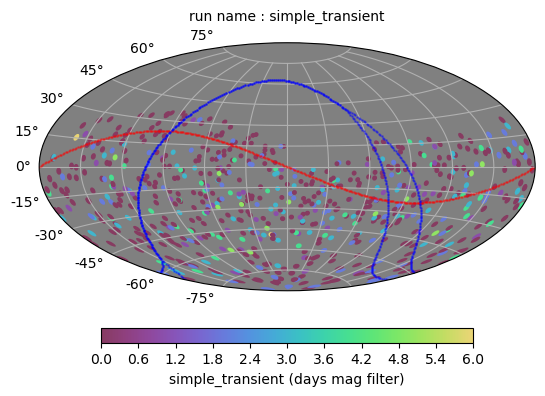

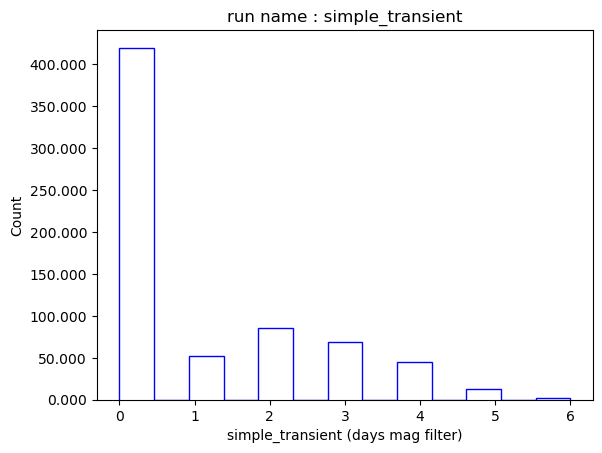

In [9]:
bg.run_all()
bg.plot_all(closefigs=False)